# Stock Market Volatility Prediction with ARCH/GARCH

This notebook guides you end-to-end through:
- Downloading daily price data
- Computing log-returns and testing for stationarity
- Detecting ARCH effects
- Fitting ARCH/GARCH-family models
- Forecasting conditional volatility and visualizing the results

> Built on: **2025-08-25**  
> Libraries: `pandas`, `numpy`, `matplotlib`, `statsmodels`, `arch`, `yfinance` (optional)


## 1) Setup

If you're running this on your own machine, install dependencies in your environment:
```bash
pip install pandas numpy matplotlib statsmodels arch yfinance
```
If `yfinance` is blocked or unavailable, place a CSV with at least a **Date** and **Close** column and set `USE_CSV = True` below.


In [2]:
# === Imports ===
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# The 'arch' package for GARCH
from arch import arch_model

# Optional: yfinance for data download
try:
    import yfinance as yf
except Exception as e:
    yf = None
    print('yfinance not available:', e)


yfinance not available: No module named 'yfinance'


## 2) Parameters

- `TICKER`: e.g., `^NSEI` (NIFTY 50), `^GSPC` (S&P 500), `RELIANCE.NS`, `TCS.NS`, `TSLA`
- `START`, `END`: ISO dates
- `USE_CSV`: set to True to read a local CSV like `data.csv` with columns: `Date`, `Close`


In [3]:
# === Parameters ===
TICKER = "^NSEI"        # NIFTY 50 index
START  = "2015-01-01"
END    = None            # None means up to latest available
USE_CSV = False          # Set True to load from CSV
CSV_PATH = "prices.csv"  # If USE_CSV=True, set your CSV path here

# Forecast horizon (days)
FORECAST_HORIZON = 30
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## 3) Load Data

This will try to download from Yahoo Finance if `USE_CSV` is False and `yfinance` is available; otherwise it reads a CSV.


In [9]:
import yfinance as yf

# === Load Prices ===
if USE_CSV:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV file not found at {CSV_PATH}. Please provide a CSV with Date, Close columns.")
    df = pd.read_csv(CSV_PATH)
    # Standardize columns
    if 'Date' not in df.columns or 'Close' not in df.columns:
        raise ValueError('CSV must contain Date and Close columns.')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')
    prices = df['Close'].astype(float)
    prices.name = "Close"
else:
    if yf is None:
        raise ImportError('yfinance not available and USE_CSV=False. Install yfinance or provide a CSV.')
    data = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
    if data.empty:
        raise ValueError('No data returned. Check ticker symbol or date range.')
    prices = data['Close']
    prices.name = "Close"

print('Data range:', prices.index.min().date(), 'to', prices.index.max().date())
prices.head()


Data range: 2015-01-02 to 2025-08-25


Ticker,^NSEI
Date,
2015-01-02,8395.450195
2015-01-05,8378.400391
2015-01-06,8127.350098
2015-01-07,8102.100098
2015-01-08,8234.599609


## 4) Compute Log Returns

\( r_t = \ln(P_t / P_{t-1}) \)


In [13]:
# === Log Returns ===
returns = np.log(prices / prices.shift(1)).dropna()
returns.name = "log_return"

returns_df = pd.concat([prices, returns], axis=1).dropna()
returns_df.head()


Ticker,^NSEI,^NSEI
Date,,
2015-01-05,8378.400391,-0.002033
2015-01-06,8127.350098,-0.030422
2015-01-07,8102.100098,-0.003112
2015-01-08,8234.599609,0.016221
2015-01-09,8284.500000,0.006042


## 5) Exploratory Data Analysis (EDA)

We'll look at the closing price series and log-returns to spot volatility clustering.


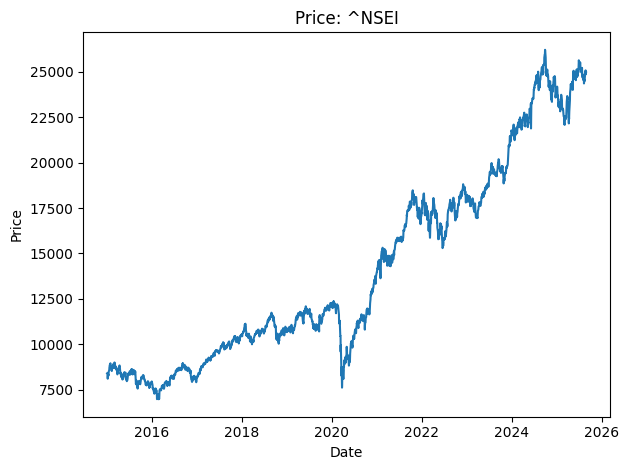

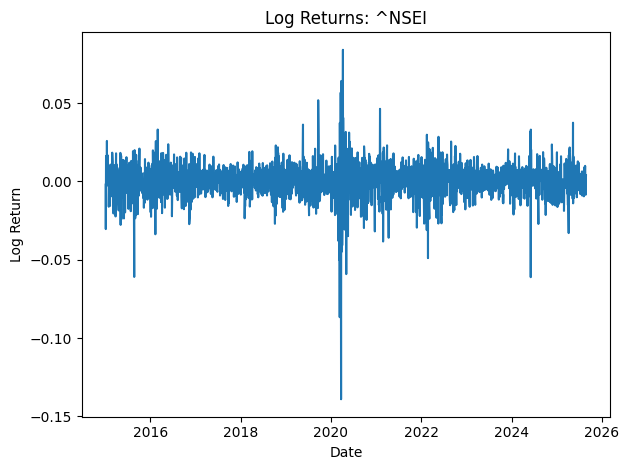

In [14]:
# === Plot: Price over time ===
plt.figure()
plt.plot(prices.index, prices.values)
plt.title(f'Price: {TICKER}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# === Plot: Log returns over time ===
plt.figure()
plt.plot(returns.index, returns.values)
plt.title(f'Log Returns: {TICKER}')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.tight_layout()
plt.show()


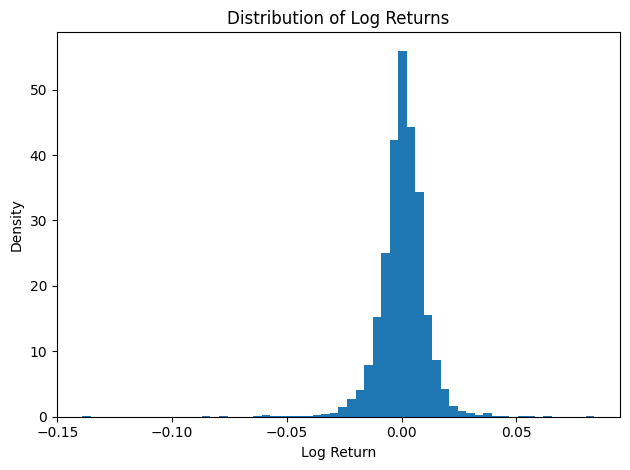

In [15]:
# === Histogram of returns ===
plt.figure()
plt.hist(returns.values, bins=60, density=True)
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


## 6) Stationarity Check (ADF Test)

We expect returns to be stationary, but it's good to confirm.


In [16]:
# === ADF test on returns ===
adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = adfuller(returns.values, autolag='AIC')
print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Critical Values:', crit_vals)


ADF Statistic: -14.183783625033884
p-value: 1.9084205394474468e-26
Critical Values: {'1%': -3.4328598727101833, '5%': -2.862648868616968, '10%': -2.5673602902877883}


## 7) ARCH Effects

We test for autocorrelation in **squared returns** (volatility clustering).

<Figure size 640x480 with 0 Axes>

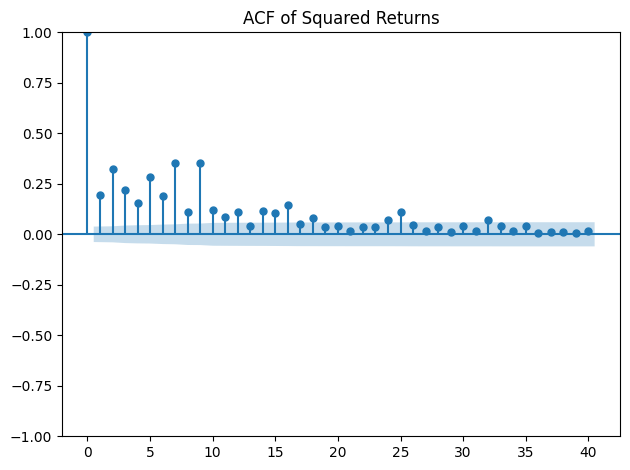

<Figure size 640x480 with 0 Axes>

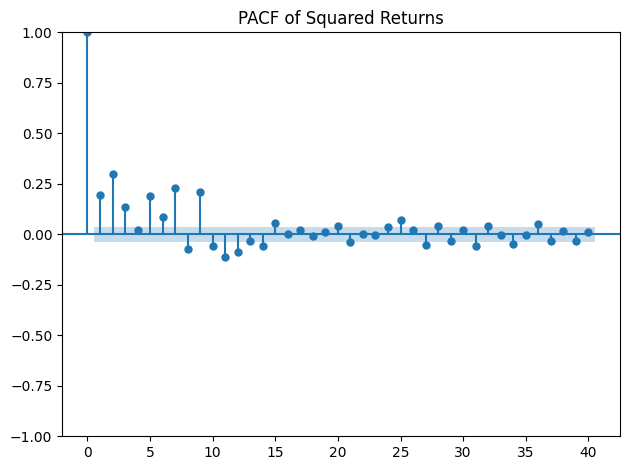

Ljung-Box on squared returns:
        lb_stat  lb_pvalue
10  1594.083957        0.0
20  1802.743526        0.0
30  1870.688702        0.0

Engle ARCH LM test:
LM stat: 676.1817378964988 p-value: 8.129748755440866e-139 F-stat: 90.877016275635 F p-value: 3.2252217793263663e-161


In [17]:
# === ACF/PACF of squared returns ===
squared = returns**2

plt.figure()
plot_acf(squared, lags=40)
plt.title('ACF of Squared Returns')
plt.tight_layout()
plt.show()

plt.figure()
plot_pacf(squared, lags=40, method='ywm')
plt.title('PACF of Squared Returns')
plt.tight_layout()
plt.show()

# === Ljung-Box on squared returns ===
lb = acorr_ljungbox(squared, lags=[10, 20, 30], return_df=True)
print('Ljung-Box on squared returns:')
print(lb)

# === Engle's ARCH LM test ===
arch_lm = het_arch(returns)
print('\nEngle ARCH LM test:')
print('LM stat:', arch_lm[0], 'p-value:', arch_lm[1], 'F-stat:', arch_lm[2], 'F p-value:', arch_lm[3])


## 8) Fit ARCH/GARCH Models

We'll start with a simple **GARCH(1,1)** with normal errors, then you can try alternatives:
- **ARCH(q)**
- **GJR-GARCH** (leverage/asymmetry)
- **EGARCH**


In [18]:
# === Fit a baseline GARCH(1,1) ===
# Mean: constant; Volatility: GARCH(1,1); Errors: Normal
am = arch_model(returns * 100, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = am.fit(disp='off')
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^NSEI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3392.34
Distribution:                  Normal   AIC:                           6792.68
Method:            Maximum Likelihood   BIC:                           6816.17
                                        No. Observations:                 2620
Date:                Mon, Aug 25 2025   Df Residuals:                     2619
Time:                        18:29:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0683  1.699e-02      4.021  5.789e-05 [3.503e-0

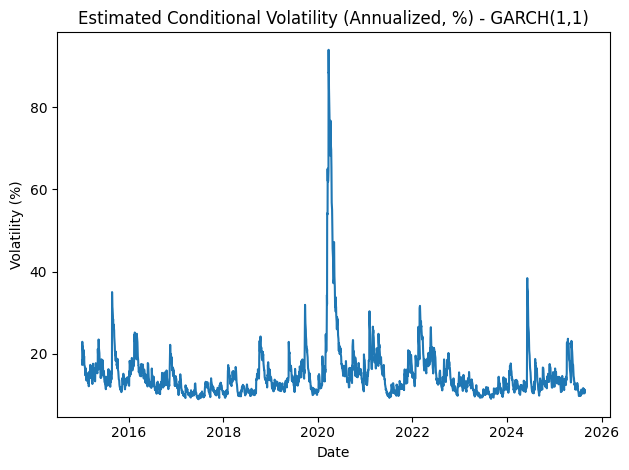

In [19]:
# === Plot conditional volatility (in % annualized approx) ===
# res.conditional_volatility is in same units as returns*100, i.e., percent daily.
cond_vol_daily_pct = res.conditional_volatility
cond_vol_annual_pct = cond_vol_daily_pct * np.sqrt(252)

plt.figure()
plt.plot(cond_vol_annual_pct.index, cond_vol_annual_pct.values)
plt.title('Estimated Conditional Volatility (Annualized, %) - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.show()


## 9) Volatility Forecast

We forecast the next 30 days of conditional variance and convert to annualized volatility (%).


In [21]:
# === Forecast next N days ===
forecasts = res.forecast(horizon=FORECAST_HORIZON, reindex=True)

# Variance forecasts for each horizon; take day 1-ahead series for simplicity
variance_forecast = forecasts.variance.iloc[-1]  # last row (most recent forecast origins)

# Convert variance (of returns*100) to std dev (daily %), then annualize
daily_vol_pct = np.sqrt(variance_forecast)
annual_vol_pct = daily_vol_pct * np.sqrt(252)

# Build forecast index (business days forward)
last_date = returns.index[-1]
forecast_index = pd.bdate_range(last_date, periods=FORECAST_HORIZON+1, inclusive="both")[1:]

forecast_df = pd.DataFrame({
    'daily_vol_pct': daily_vol_pct.values,
    'annual_vol_pct': annual_vol_pct.values
}, index=forecast_index)

print('Forecast (head):')
print(forecast_df.head())


Forecast (head):
            daily_vol_pct  annual_vol_pct
2025-08-26       0.678488       10.770665
2025-08-27       0.689851       10.951040
2025-08-28       0.700709       11.123418
2025-08-29       0.711097       11.288311
2025-09-01       0.721042       11.446180


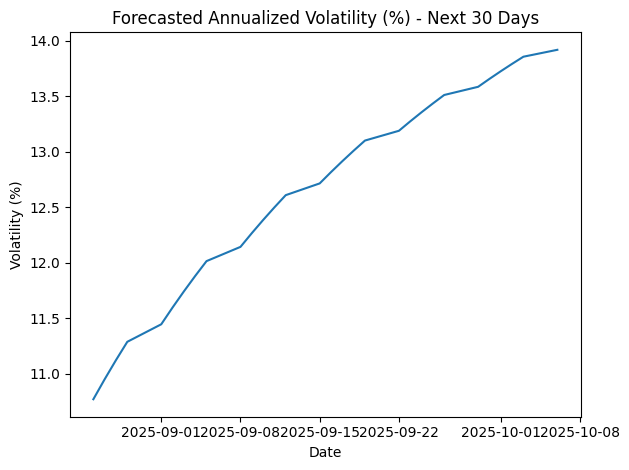

In [22]:
# === Plot forecasted annualized volatility ===
plt.figure()
plt.plot(forecast_df.index, forecast_df['annual_vol_pct'].values)
plt.title(f'Forecasted Annualized Volatility (%) - Next {FORECAST_HORIZON} Days')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.show()


## 10) Try Alternatives & Compare (AIC/BIC)

Below are examples for ARCH(1), GJR-GARCH(1,1), and EGARCH(1,1). Feel free to extend.


In [23]:
# === ARCH(1) ===
arch1 = arch_model(returns * 100, mean='Constant', vol='ARCH', p=1, dist='normal').fit(disp='off')

# === GJR-GARCH(1,1) ===
gjr = arch_model(returns * 100, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='normal').fit(disp='off')

# === EGARCH(1,1) ===
egarch = arch_model(returns * 100, mean='Constant', vol='EGARCH', p=1, q=1, dist='normal').fit(disp='off')

comp = pd.DataFrame({
    'Model': ['GARCH(1,1)', 'ARCH(1)', 'GJR-GARCH(1,1)', 'EGARCH(1,1)'],
    'AIC': [res.aic, arch1.aic, gjr.aic, egarch.aic],
    'BIC': [res.bic, arch1.bic, gjr.bic, egarch.bic]
}).sort_values('AIC')
comp


,Model,AIC,BIC
2,"GJR-GARCH(1,1)",6731.654742,6761.009390
0,"GARCH(1,1)",6792.682062,6816.165780
3,"EGARCH(1,1)",6801.471778,6824.955497
1,ARCH(1),7194.744809,7212.357598


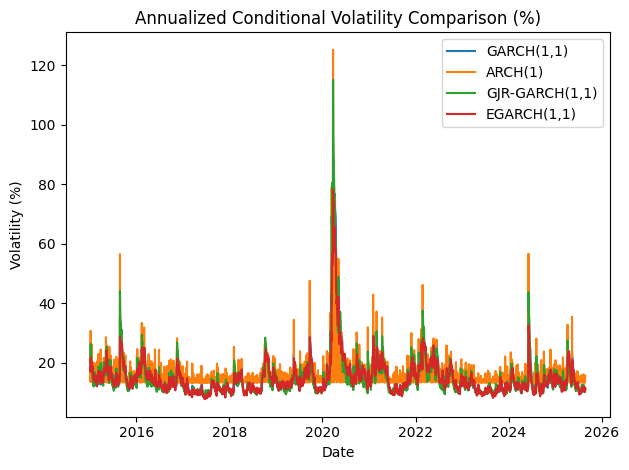

In [24]:
# === Compare fitted conditional volatilities (annualized, %) ===
vols = pd.DataFrame({
    'GARCH11': res.conditional_volatility,
    'ARCH1': arch1.conditional_volatility.reindex(res.conditional_volatility.index),
    'GJRGARCH': gjr.conditional_volatility.reindex(res.conditional_volatility.index),
    'EGARCH': egarch.conditional_volatility.reindex(res.conditional_volatility.index)
}).dropna()

vols_ann = vols * np.sqrt(252)

plt.figure()
plt.plot(vols_ann.index, vols_ann['GARCH11'].values, label='GARCH(1,1)')
plt.plot(vols_ann.index, vols_ann['ARCH1'].values, label='ARCH(1)')
plt.plot(vols_ann.index, vols_ann['GJRGARCH'].values, label='GJR-GARCH(1,1)')
plt.plot(vols_ann.index, vols_ann['EGARCH'].values, label='EGARCH(1,1)')
plt.title('Annualized Conditional Volatility Comparison (%)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()


## 11) Realized vs Predicted Volatility (Optional)

Compute rolling realized volatility and compare with model-implied volatility.


In [31]:
# Force both series into 1D arrays
garch_vol = np.asarray(cond_vol_annual_pct).reshape(-1)   # shape -> (2620,)
realized_vol = np.asarray(rv_ann_pct).reshape(-1)         # shape -> (2620,)

print("Shapes:")
print("garch_vol:", garch_vol.shape)
print("realized_vol:", realized_vol.shape)

# Align lengths
min_len = min(len(garch_vol), len(realized_vol))

# Build DataFrame with aligned index
vol_compare = pd.DataFrame({
    'GARCH11_ann_%': garch_vol[:min_len],
    'Realized_ann_%': realized_vol[:min_len]
}, index=rv_ann_pct.index[:min_len])

print(vol_compare.head())


Shapes:
garch_vol: (2620,)
realized_vol: (2620,)
            GARCH11_ann_%  Realized_ann_%
Date                                     
2015-01-05      18.271918             NaN
2015-01-06      17.263768             NaN
2015-01-07      22.888802             NaN
2015-01-08      21.547696             NaN
2015-01-09      21.759688             NaN


## 12) Save Key Artifacts

You can save comparison tables and forecast to CSV for your report.


In [32]:
# === Save outputs ===
comp.to_csv('model_comparison.csv', index=False)
forecast_df.to_csv('vol_forecast.csv')
vol_compare.to_csv('vol_realized_vs_model.csv')
print('Saved: model_comparison.csv, vol_forecast.csv, vol_realized_vs_model.csv')


Saved: model_comparison.csv, vol_forecast.csv, vol_realized_vs_model.csv


## 13) Next Steps / Report Ideas

- Try **Student-t** or **Skewed-t** error distributions for fat tails: `dist='t'` or `dist='skewt'`.
- Add a **mean model** (e.g., ARMA) for returns: `mean='ARX'` with lags.
- Compare multiple tickers (NIFTY, SENSEX, sector indices, top stocks).
- Event study: mark crisis periods (e.g., 2020 crash) and discuss volatility spikes.
- Backtest a simple strategy that sizes exposure inversely to volatility (risk parity flavor).

**Deliverables to include in your submission:**
- This notebook (cleaned and re-run) with outputs.
- `model_comparison.csv`, `vol_forecast.csv`, `vol_realized_vs_model.csv`.
- A 1–2 page PDF summary of findings with charts.
